# Spotify Data Analysis

In [1]:
# import libraries
import sys
import pickle
import string
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn.apionly as sns #sets up styles and gives us more plotting options
import sklearn.metrics as metrics
import math
from datetime import date
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
import statsmodels.api as sm
%matplotlib inline

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Local Data file directory (Update this with your own directory)

In [2]:
# Local data folder to save data to and pull data from
### NOTE to partners: comment out mine; use your own local folder path
### ^^ you'll have to continutally check this with each push/pull from GitHub ^^

# Daniel
# data_folder = "/Users/dannynightingale/Documents/Harvard 2017-2018/Harvard 2017-2018 Fall/CS 109a/Spotify Final Project/data/"

# Hartin
data_folder = "/Users/hartincode/Documents/Harvard/Senior_Fall/CS109/final_project/Spotify_Data/"

# Will
# data_folder =

## Load in the Data

In [3]:
# unpickle 
spotify_data = pd.read_pickle(data_folder + "spotify_data")

In [4]:
# rename "track_populatrity" to "track_popularity"
spotify_data.rename(index=str, columns={"track_populatrity": "track_popularity"}, inplace=True)

In [5]:
print(spotify_data.shape)
spotify_data[3000:].head(3)

(2616111, 40)


,followers,pl_description,pl_href,pl_id,pl_length,pl_name,track_added,track_album_id,track_album_name,track_artists_id1,...,track_key,track_liveness,track_loudness,track_mode,track_speechiness,track_tempo,track_time_signature,track_valence,track_artist_genres,track_artist_popularity
1857970,529249,Your #1 source for the biggest Electronic Danc...,https://api.spotify.com/v1/users/elainelin/pla...,6XVhyMuFRS1212blJHTED4,122,Zoedic - Dance Music Updated Weekly - House Mu...,2017-05-16T01:02:14Z,2XL6YeLpngWTdofLEgDY4v,In Da Club,1dbzT291PCwwYJK0l3Tr1n,...,4.0,0.352,-5.335,1.0,0.0603,90.038,4.0,0.5220,"['progressive trance', 'trance', 'uplifting tr...",51.5
341725,529249,Your #1 source for the biggest Electronic Danc...,https://api.spotify.com/v1/users/elainelin/pla...,6XVhyMuFRS1212blJHTED4,122,Zoedic - Dance Music Updated Weekly - House Mu...,2017-09-18T01:29:59Z,5l5gR4rh26QI3fijGFTDrp,Dusk Till Dawn (Radio Edit),5ZsFI1h6hIdQRw2ti0hz81,...,11.0,0.106,-6.593,0.0,0.0390,180.043,4.0,0.0967,"['dance pop', 'pop', 'post-teen pop', 'tropica...",92.5
49373,529249,Your #1 source for the biggest Electronic Danc...,https://api.spotify.com/v1/users/elainelin/pla...,6XVhyMuFRS1212blJHTED4,122,Zoedic - Dance Music Updated Weekly - House Mu...,2017-06-01T03:44:38Z,5wtHzowB37Fre3iXWQW5v5,More Than You Know,2XnBwblw31dfGnspMIwgWz,...,5.0,0.290,-4.989,0.0,0.0339,123.070,4.0,0.5340,"['big room', 'edm', 'electro house', 'pop', 't...",84.0


In [6]:
# variable descriptions
## spotify field descriptions from: https://developer.spotify.com/web-api/object-model/
var_descr = [ \
"Number of Playlist Followers", \
"Playlist Description", \
"Playlist href (for querying spotify)", \
"Playlist Spotify ID", \
"Number of songs in playlist", \
"Playlist Name", \
"Time track added to playlist", \
"Track Album Spotify ID", \
"Track Album Name", \
"Track Artist 1 Spotify ID", \
"Track Artist 2 Spotify ID", \
"Track Artist 3 Spotify ID", \
"Track Artist 4 Spotify ID", \
"Track Artist 5 Spotify ID", \
"Track Artist 1 Name", \
"Track Artist 2 Name", \
"Track Artist 3 Name", \
"Track Artist 4 Name", \
"Track Artist 5 Name", \
"Track Explicit (True or False)", \
"Track href (for querying spotify)", \
"Track Spotify ID", \
"Track ISRC number (for linking to other datasets)", \
"Track Length (milliseconds)", \
"Track Name", \
"""Track Popularity (The popularity of a track is a value between 0 and 100, with 
100 being the most popular. The popularity is calculated by algorithm and is based, 
in the most part, on the total number of plays the track has had and how recent those plays are.)""", \
"""Track Acousticness (A confidence measure from 0.0 to 1.0 of whether the  
track is acoustic. 1.0 represents high confidence the track is acoustic)""", \
"""Track Danceability (Danceability describes how suitable a track is for dancing
based on a combination of musical elements including tempo, rhythm stability, beat
strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable)""", \
"""Track Energy (Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity 
and activity. Typically, energetic tracks feel fast, loud, and noisy)""", \
"""Track Instrumentalness (Predicts whether a track contains no vocals.
Rap or spoken word tracks are clearly vocal. The closer the instrumentalness
value is to 1.0, the greater likelihood the track contains no vocal content)""", \
"""Track Key (The key the track is in. Integers map to pitches using standard Pitch
Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on)""", \
"""Track Liveness (Detects the presence of an audience in the recording.
Higher liveness values represent an increased probability that the track was performed live.
A value above 0.8 provides strong likelihood that the track is live.)""", \
"""Track Loudness (The overall loudness of a track in decibels (dB). Loudness values are
averaged across the entire track and are useful for comparing relative loudness of tracks)""", \
"""Track Mode (Mode indicates the modality (major or minor) of a track, the type of scale from
which its melodic content is derived. Major is represented by 1 and minor is 0.)""", \
"""Track Speechiness (Speechiness detects the presence of spoken words in a track. The more
exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0
the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken
words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech,
either in sections or layered, including such cases as rap music. Values below 0.33 most likely
represent music and other non-speech-like tracks.)""", \
"Track Tempo (The overall estimated tempo of a track in beats per minute (BPM))", \
"Track Time Signiture (An estimated overall time signature of a track (int))", \
"""Track Valence (A measure from 0.0 to 1.0 describing the musical positiveness conveyed
by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric),
while tracks with low valence sound more negative (e.g. sad, depressed, angry).)""", \
"Track Artist Genres (List of all of the genres associated with all of the track artists)", \
"Track Artist Popularity (Average Popularity of the artists for the track (Spotify Calculated Popularity))"]

class font:
   bold = '\033[1m'
   und = '\033[4m'
   end = '\033[0m'

# print variable summary
print(font.bold + font.und + "Variable: " + font.end + font.und + "Description" + font.end)
for index, var in enumerate(spotify_data.columns):
    print(font.bold + var + ":" + font.end, var_descr[index])

Variable: Description
followers: Number of Playlist Followers
pl_description: Playlist Description
pl_href: Playlist href (for querying spotify)
pl_id: Playlist Spotify ID
pl_length: Number of songs in playlist
pl_name: Playlist Name
track_added: Time track added to playlist
track_album_id: Track Album Spotify ID
track_album_name: Track Album Name
track_artists_id1: Track Artist 1 Spotify ID
track_artists_id2: Track Artist 2 Spotify ID
track_artists_id3: Track Artist 3 Spotify ID
track_artists_id4: Track Artist 4 Spotify ID
track_artists_id5: Track Artist 5 Spotify ID
track_artists_name1: Track Artist 1 Name
track_artists_name2: Track Artist 2 Name
track_artists_name3: Track Artist 3 Name
track_artists_name4: Track Artist 4 Name
track_artists_name5: Track Artist 5 Name
track_explicit: Track Explicit (True or False)
track_href: Track href (for querying spotify)
track_id: Track Spotify ID
track_isrc: Track ISRC number (for linking to other datasets)
track_length_ms: Track Length (millise

In [7]:
# percent "missingness" (NaN) for each variable (only wrong for track_artist_genres)
print(font.bold + "Percent Missing Values for each field:" + font.end)
(spotify_data.isnull().sum()/spotify_data.shape[0])*100

Percent Missing Values for each field:


followers                   0.000000
pl_description             49.556804
pl_href                     0.000000
pl_id                       0.000000
pl_length                   0.000000
pl_name                     0.000000
track_added                 0.425517
track_album_id              0.617978
track_album_name            0.267382
track_artists_id1           0.617978
track_artists_id2          75.638992
track_artists_id3          92.742319
track_artists_id4          97.734462
track_artists_id5          99.104549
track_artists_name1         0.195443
track_artists_name2        75.665253
track_artists_name3        92.749428
track_artists_name4        97.737634
track_artists_name5        99.104663
track_explicit              0.000000
track_href                  0.617978
track_id                    0.617978
track_isrc                  0.760786
track_length_ms             0.000000
track_name                  0.070754
track_popularity            0.000000
track_acousticness          0.745305
t

Note: There seems to be relatively few missing values, except for additional artists and playlist descriptions. These are variables that we would expect to have missing values for / it is not a big problem. 

## Clean the data

In [ ]:
# create indicator variables for track key
spotify_data = pd.get_dummies(spotify_data, columns=['track_key'], drop_first=True)

# calculate the number of days before download that a song was added to the playlist
spotify_data['track_days'] = spotify_data['track_added'].map(lambda x: (date(2017, 11, 22) \
                            - date(int(x[0:4]), int(x[5:7]), int(x[8:10]))).days, na_action='ignore')

# dummy variable for if the playlist has a description
spotify_data['pl_has_description'] = np.where(spotify_data['pl_description'].isnull(), 0, 1)

# get the playlist user
spotify_data['user'] = spotify_data['pl_href'].map(lambda x: x[x.find("users/")+6:x.find("/playlists")])

# dummy for created by spotify
spotify_data['pl_user_spotify'] = np.where(spotify_data['user'] == "spotify", 1, 0)

# dummy for user has name
spotify_data['pl_user_has_name'] = np.where(spotify_data['user'].map(lambda x: x.isdigit()), 0, 1)

# playlist has more than one artist dummy variable (only small error in this variable do to missingness of 1st artist)
spotify_data['track_mult_artists'] = np.where(spotify_data['track_artists_id2'].isnull(), 0, 1)

# create var for the number of tracks that we have for each playlist in our data
number_tracks_data = pd.DataFrame({'num_tracks' : spotify_data.groupby("pl_id").size()}).reset_index()
spotify_data = spotify_data.merge(number_tracks_data, left_on=["pl_id"], right_on=["pl_id"], how='left')

# get umbrella genres (ones that encompass a large number of subsets), add dummies for each one to the dataset
umbrella_genres = ['pop', 'indie', 'country', 'rap', 'rock', 'classical', 'metal', 'jazz', 'dance', 'acoustic']
for genre in umbrella_genres:
    spotify_data[genre] = np.where(spotify_data['track_artist_genres'].map(lambda x: x.find(genre)) < 0, 0, 1)

# ------- multiple sub-genres missing:
# ------- folk (under indie), RandB (under rap), singer (under acoustic),
# ------- songwriter (under acoustic), singer-songwriter (under acoustic)

# drop the small percent (1.8% of observations) where the number of songs do not match the playlist length
# (these are the ones where we are missing some of the tracks in the playlist)
spotify_data_cleaned = spotify_data.loc[spotify_data.pl_length == spotify_data.num_tracks]

# no longer need num_tracks variable (same as pl_length variable)
del spotify_data_cleaned['num_tracks']

# generate list of unique playlist IDs - we have about 1000 unique playlists
pl_IDs = np.sort(spotify_data_cleaned['pl_id'].unique())
len(pl_IDs)

In [ ]:
print(spotify_data_cleaned.shape)
spotify_data_cleaned.head()

In [ ]:
# re-check percent "missingness" (NaN) for each variable, cleaned dataset
print(font.bold + "Percent Missing Values for each field:" + font.end)
(spotify_data_cleaned.isnull().sum()/spotify_data_cleaned.shape[0])*100

In [ ]:
# try collapsing by playlist by mean for all of the quantitative variables
playlist_data = spotify_data_cleaned.groupby('pl_id', as_index=False).mean()

In [ ]:
# rename all of the variables that are averages
playlist_data.columns = [str(col) + '_avg' for col in playlist_data.columns]
playlist_data.rename(index=str, columns={"pl_id_avg": "pl_id", "pl_has_description_avg" : "pl_description",
                        "pl_user_spotify_avg" : "pl_user_spotify", "pl_user_has_name_avg" : "pl_user_has_name",
                        "followers_avg": "followers", "pl_length_avg" : "pl_length"}, inplace=True)

In [ ]:
# create variable for age of playlist (when first song added)
playlist_age = spotify_data_cleaned.groupby('pl_id', as_index=False)['track_days'].max()

# merge to playlist dataset
playlist_data = playlist_data.merge(playlist_age, left_on=["pl_id"], right_on=["pl_id"], how='left')

# rename variable
playlist_data.rename(index=str, columns={"track_days": "pl_age"}, inplace=True)

In [ ]:
# get dictionary of all unique genres represented in a playlist
genres = spotify_data_cleaned.groupby('pl_id', as_index=False)['track_artist_genres'].groups

# convert the dictionary to lists of unique genres and number of them
playlist_genres = []
playlist_variety = []
for ID in pl_IDs:
    entry = list(genres[ID])
    playlist_genres.append(entry)
    playlist_variety.append(len(entry))

# add the lists to playlist dataframe
# playlist_data['pl_genres'] = playlist_genres
playlist_data['pl_genres_variety'] = playlist_variety

In [ ]:
# # THIS CELL TAKES ABOUT 40 MINUTES

# # initialize counter, dictionary for most common genre
# top_five = {}
# i = 0

# # iterate through all playlist IDs
# for ID in pl_IDs:
    
#     # print out progress percent
#     status = round(100*(i / len(pl_IDs)), 3)
#     sys.stdout.write(f'\r{status}%')
#     sys.stdout.flush()
#     i += 1
    
#     # extract dataframe for current playlist, initialize dictionary counting genres
#     current_playlist = spotify_data_cleaned[spotify_data_cleaned['pl_id'] == ID]
#     genre_counts = {}
    
#     # iterate through each track in the playlist, parse out each genre
#     for entry in current_playlist['track_artist_genres']:
#         genres = entry.split("'")[1::2]
        
#         # for all genres identified for the track, update count in playlist genre dictionary
#         for key in genres:
#             if key in genre_counts:
#                 genre_counts[key] += 1
#             else:
#                 genre_counts[key] = 1
    
#     # record most common genres represented in the playlist
#     top_five[ID] = list(reversed(sorted(genre_counts, key=genre_counts.get)[-5:]))

# # create dataframe from top_5 list, rename columns
# playlist_genres = pd.DataFrame.from_dict(top_five, orient='index')
# playlist_genres.columns = ["mcg_01", "mcg_02", "mcg_03", "mcg_04", "mcg_05"]
# playlist_genres.head()

In [ ]:
# # merge to playlist dataset
# playlist_data = playlist_data.merge(playlist_genres, left_on=["pl_id"], right_on=["pl_id"], how='left')

In [ ]:
# define the number of followers that determines a popular (top 5%) playlists
level, total = 0.95, len(playlist_data['followers'])
index = int(level * total)
success_threshold = int(sorted(playlist_data['followers'])[index])
print('Top 5% of playlists have' +font.bold+ f' {success_threshold} ' +font.end+ 'followers or more')

# determine if a playlist is successful
playlist_data['pl_successful'] = np.where(playlist_data['followers'] > success_threshold, 1, 0)

In [ ]:
# drop missing; few playlists
playlist_data = playlist_data.dropna(how = 'any')

In [ ]:
playlist_data.head()

In [ ]:
# Example of row of data (and fields)
playlist_data.iloc[0]

## Some EDA

In [ ]:
# Plot a scatter plot of followers vs playlist length
playlist_data['length'] = playlist_data['pl_length'].apply(lambda x: round(x / 25))
length = playlist_data['length'].values
followers = playlist_data['followers'].values
length_mean = playlist_data.groupby('length', as_index=False)['followers'].mean()

fig, ax = plt.subplots(1, figsize=(15, 8))

ax.scatter(length, followers, color='blue', alpha=0.2, label='Data Points', s=15)
ax.plot(length_mean['length'], length_mean['followers'], color='red', label='Mean (by length)', alpha=0.6)

#ax.set_xticks(np.arange(0, 1, 20))
#ax.set_yticks(np.arange(0, 200, 25))
ax.set_xticks(np.arange(0, 21))
ax.set_xticklabels(np.arange(0, 510, 25),fontsize=11)
ax.set_xlim([0,20])
ax.set_ylim([0,200000])
ax.set_xlabel('Number of Songs in Playlist (rounded to nearest 25)')
ax.set_ylabel('Playlist Followers')
ax.set_title('Spotify Data:\nNumber of Followers by Length of Playlist')
ax.legend(loc='best')
del playlist_data['length']

In [ ]:
# Plot a scatter plot of followers vs average track popularity 
playlist_data['popularity'] = playlist_data['track_popularity_avg'].apply(lambda x: round(x))
popularity = playlist_data['popularity'].values
followers = playlist_data['followers'].values
pop_mean = playlist_data.groupby('popularity', as_index=False)['followers'].mean()

fig, ax = plt.subplots(1, figsize=(15, 8))

ax.scatter(popularity, followers, color='blue', alpha=0.2, label='Data Points', s=15)
ax.plot(pop_mean['popularity'], pop_mean['followers'], color='red', label='Mean (by popularity)', alpha=0.6)

#ax.set_xticks(np.arange(0, 1, 20))
#ax.set_yticks(np.arange(0, 200, 25))
# ax.set_xticks(np.arange(0, 21))
# ax.set_xticklabels(np.arange(0, 510, 25),fontsize=11)
# ax.set_xlim([0,100])
ax.set_ylim([0,250000])
ax.set_xlabel('Average Song Popularity (Score out of 100)')
ax.set_ylabel('Playlist Followers')
ax.set_title('Spotify Data:\nNumber of Followers by Average Song Popularity')
ax.legend(loc='best')
del playlist_data['popularity']

In [ ]:
# Plot a scatter plot of followers vs percent of songs in certain keys
keys = []
for i in range(1,12):
    keys.append(playlist_data[f'track_key_{i}.0_avg'].values)
followers = playlist_data['followers'].values

fig, ax = plt.subplots(1, figsize=(15, 8))
for i in range(11):
    k = i + 1
    ax.scatter(keys[i], followers, label=f'{k}', alpha=0.3)

ax.set_xlabel('Percent of songs in Key')
ax.set_ylabel('Playlist Followers')
ax.set_title('Spotify Data:\nNumber of Followers by Key')
ax.legend(loc='best')

In [ ]:
# quick scatter of followers by playlist age
age = playlist_data['pl_age'].values
followers = playlist_data['followers'].values

fig, ax = plt.subplots(1, figsize=(15, 8))

ax.scatter(age, followers, color='blue', alpha=0.2, label='Data Points', s=15)

#ax.set_xticks(np.arange(0, 1, 20))
#ax.set_yticks(np.arange(0, 200, 25))
# ax.set_xticks(np.arange(0, 21))
# ax.set_xticklabels(np.arange(0, 510, 25),fontsize=11)
# ax.set_xlim([0,100])
ax.set_ylim([0,250000])
ax.set_xlabel('Age of Playlist (Days)')
ax.set_ylabel('Playlist Followers')
ax.set_title('Spotify Data:\nNumber of Followers by Age of Playlist')
ax.legend(loc='best')


## Start Building Regression Model for Predicting Followers

In [ ]:
# Split the dataset into train and test datasets
np.random.seed(9001)
msk = np.random.rand(len(playlist_data)) < 0.5
train = playlist_data[msk]
test = playlist_data[~msk]

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

# Standardize Continuous Predictors
col_stand = np.concatenate((train.columns[2:-5], train.columns[-2:]))
test[col_stand] = (test[col_stand] - train[col_stand].mean()) / train[col_stand].std()
train[col_stand] = (train[col_stand] - train[col_stand].mean()) / train[col_stand].std()

train.head()

In [ ]:
# Try a basic linear regression

# create datasets
x_var = train.columns[2:]
x_train = train[x_var].values
y_train = train["followers"].values

x_test = test[x_var].values
y_test = test["followers"].values

# Create linear regression object
regression_model = LinearRegression(fit_intercept=True)
results = regression_model.fit(x_train, y_train)

yhat_train = results.predict(x_train)
yhat_test = results.predict(x_test)

# The R^2 values
print('  Train R^2:', r2_score(y_train, yhat_train))
print('  Test R^2:', r2_score(y_test, yhat_test), "\n")

In [ ]:
### Use lasso (with cross-validation) to determine which variables are important to our model (and which ones aren't)

# Lambda values that we want to try
lambda_val = []
for i in np.arange(start=-5, stop=30):
    lambda_val.append(math.pow(10,i))

lambdas = np.array(lambda_val).tolist()    

# create datasets
x_var = train.columns[2:]
x_train = train[x_var].values
y_train = train["followers"].values
x_test = test[x_var].values
y_test = test["followers"].values

# Run Lasso CV regression on train dataset
lasso_regression = LassoCV(alphas=lambdas, fit_intercept=True)
results = lasso_regression.fit(x_train, y_train)
yhat_train = results.predict(x_train)
yhat_test = results.predict(x_test)

# # Get CV score
# scores = cross_val_score(lasso_regression, x_train, y_train, cv=5)
# cv_score = scores.mean()

# print R^2 values
print("Lasso Model:")
print("  Train R^2:", r2_score(y_train, yhat_train))
print("  Test R^2:", r2_score(y_test, yhat_test))

# print important coefficients
print("\nLasso, Important Variables:")
important_var = []
coeff = []
for i, x in enumerate(x_var):
    if(results.coef_[i] > .00000001):
        important_var.append(x)
        coeff.append(results.coef_[i])
        
for i, var in enumerate(important_var):
    print("  {}: {}, Coeff = {}".format(i + 1, var, round(coeff[i], 1)))

# for i, x in enumerate(x_var):
#     print("{}: Coef = {}".format(x, results.coef_[i])) 

In [ ]:
# predictor selection using PCA dimension reduction and k-fold cross validation

# create datasets
x_var = train.columns[2:]
x_train = train[x_var].values
y_train = train["followers"].values
x_test = test[x_var].values
y_test = test["followers"].values

# initialize linear model, k-fold, range of principal component values, and lists
regression_model = LinearRegression(fit_intercept=True)
kf = KFold(n_splits=5)
pca_nums = np.arange(1, 20)
expl_var_dict = {}
x_val_scores = []
validation_R_sqs = []

for i in pca_nums:
    
    # initialize PCA for number of desired components
    pca = PCA(n_components=i)
    pca.fit_transform(x_train)
    # fill the dictionary with key, value = pca, explained variance
    expl_var_dict[i] = pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()
    
    # 5-fold cross validation
    for train_index, val_index in kf.split(x_train):
        
        # split data into train and validate 
        X_train, X_val = x_train[train_index], x_train[val_index]
        Y_train, Y_val = y_train[train_index], y_train[val_index]
        
        # fit PCA on the train k-fold
        pca.fit_transform(X_train)
        
        # create PCA-version of data
        X_train_pca = pca.transform(X_train)
        X_val_pca = pca.transform(X_val)

        # fit linear model and calculate r-squared
        regression_model.fit(X_train_pca, Y_train)
        validation_R_sqs.append(regression_model.score(X_val_pca, Y_val))
    
    # record average r-squared values
    x_val_scores.append((i, np.mean(validation_R_sqs)))
    
# x_val_scores

# using arbitrary 6-component PCA, predict number of followers for a playlist
pca = PCA(n_components=6)
X_train = pca.fit_transform(x_train)

regression_model = LinearRegression(fit_intercept=True)
results = regression_model.fit(X_train, y_train)

yhat_train = results.predict(X_train)
# yhat_test = results.predict(X_test)

# The R^2 values
print('Train R^2:', r2_score(y_train, yhat_train))
# print('Test R^2:', r2_score(y_test, yhat_test), "\n")

/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of grou

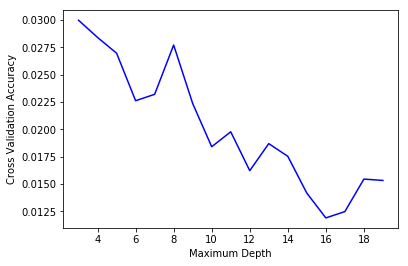

In [79]:
# create a model that, given a playlist, predicts the probability that the playlist will be "successful"

# create datasets
x_var = train.columns[2:]
x_train = train[x_var].values
y_train = train["pl_successful"].values
x_test = test[x_var].values
y_test = test["pl_successful"].values

# # stupid random forest
# rf = RandomForestClassifier(max_features= 1, n_estimators=50, oob_score=True)
# rf.fit(X, y)

# find which depth works best
# originate empty list, minimum depth, and maximum depth
depths = []
min_dep, max_dep = 3, 20

# iterate through the range of minimum to maximum depths
for i in np.arange(min_dep, max_dep, 2):
    
    # initialize decision tree model
    dtree = DecisionTreeClassifier(max_depth=i)
    
    # perform 5-fold cross validation
    scores = cross_val_score(estimator=dtree, X=x_train, y=y_train, cv=5, n_jobs=-1)
    
    # record the mean score
    depths.append((i,scores.mean()))

# plot the accuracy for each tested depth    
plt.plot(np.array(depths)[:,0], np.array(depths)[:,1], 'b-')
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Maximum Depth")
plt.show()

# train_scores = []
# test_scores = []
# # sizes = np.power(2, range(1, 10))
# sizes = [10, 20, 30, 40, 50]

# print('TREES\tTRAIN SCORE\tTEST SCORE')
# for n_trees in sizes:
#     rf = RandomForestClassifier(n_estimators=n_trees, max_features='sqrt')
#     train_score = metrics.accuracy_score(y_train, rf.fit(x_train, y_train).predict(x_train))
#     test_score = metrics.accuracy_score(y_test, rf.fit(x_train, y_train).predict(x_test))
    
#     print(f'{n_trees}' '\t%.5f' % train_score, '\t%.5f' % test_score)
    
#     train_scores.append(train_score)
#     test_scores.append(test_score)
    
# # plot the accuracy for each tested depth and probability    
# plt.plot(sizes, train_scores, label='Train')
# plt.plot(sizes, test_scores, label='Test')

# plt.ylabel("Accuracy")
# plt.xlabel("Forest Size")
# plt.legend()

In [33]:
# when prompted with a genre, return a playlist that has a high probability of being successful

# indicate the genre of interest (for the purposes of this example we use country), but
# choices are the umbrella genres: pop, indie, country, rap, rock, classical, metal, jazz, dance, acoustic
genre = 'country'
candidate_tracks = spotify_data_cleaned.loc[spotify_data_cleaned[genre] == True]

# initialize number of candidate playlists, best score, possible playlist sizes
num_candidates = 20
best_score = 0
min_size, max_size = 40, 101
pl_sizes = np.random(min_size, max_size, num_candidates)

# iterate through 20 possible playlists
for length in pl_sizes:
    
    # make playlist of random subsets of eligible tracks, rename columns
    msk = np.random.randint(len(candidate_tracks), size=length)
    songs = candidate_tracks[msk]
    songs.columns = candidate_tracks.columns
    
    # collapse into a playlist
    playlist = songs.mean()
    
    # predict probability of playlist being successful
    pl_score = 
    
    # compare to current best playlist
    if pl_score > best_score:
        best_score, best_playlist = pl_score, playlist
        
# return most promising playlist
top_score = best_score*10
print(f'Probability of playlist success: {top_score}%')
best_playlist